## 导入要用的包

In [1]:
import librosa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## 特征提取

### 调式

In [2]:
def GetMode(path,sr=22050,threshold=0.9):

    y,sr=librosa.load(path=path,sr=sr)

    #3.处理cqt下的色度向量
    threshold = 0.9 #设置绝对能量和相对能量的阈值，其余音置零，可以消除部分静音帧并起到筛选的作用
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr,threshold=threshold)
    chroma_cq [chroma_cq < threshold] = 0.0
    mean = np.mean(chroma_cq, axis=1) # 计算每一行的均值，可以代表每种音高在音乐中出现的相对时长
    # print(mean)


    #4. 调式标准向量（强化了主音和属音的寻找）
    Mode = [[2,0,1,0,1,1,0,2,0,1,0,1],# C大
    [1,0,1,0,2,1,0,1,0,2,0,1],# a小

    [1,0,2,0,1,0,1,2,0,1,0,1],# G大
    [1,0,1,0,2,0,1,1,0,1,0,2],# e小

    [0,1,2,0,1,0,1,1,0,2,0,1],# D大
    [0,1,1,0,1,0,2,1,0,1,0,2],# b小

    [0,1,1,0,2,0,1,0,1,2,0,1],# A大
    [0,2,1,0,1,0,2,0,1,1,0,1],# #f小

    [0,1,0,1,2,0,1,0,1,1,0,2],# E大
    [0,2,0,1,1,0,1,0,2,1,0,1],# #c小

    [0,1,0,1,1,0,2,0,1,0,1,2],# B大
    [0,1,0,2,1,0,1,0,2,0,1,1],# #g小

    [0,2,0,1,0,1,2,0,1,0,1,1],# #F大
    [0,1,0,2,0,1,1,0,1,0,2,1],# #d小

    [1,2,0,1,0,1,1,0,2,0,1,0],# #C大
    [1,1,0,1,0,2,1,0,1,0,2,0],# #a小


    [2,0,1,0,1,2,0,1,0,1,1,0],# F大
    [1,0,2,0,1,1,0,1,0,2,1,0],# d小

    [1,0,1,1,0,2,0,1,0,1,2,0],# bB大
    [1,0,2,1,0,1,0,2,0,1,1,0],# g小

    [1,0,1,2,0,1,0,1,1,0,2,0],# bE大
    [2,0,1,1,0,1,0,2,1,0,1,0],# c小

    [1,1,0,2,0,1,0,1,2,0,1,0],# bA大
    [2,1,0,1,0,2,0,1,1,0,1,0]]# f小

    Mode_name = ["C大调","a小调","G大调","e小调","D大调","b小调","A大调","升f小调","E大调","升c小调",
               "B大调","升g小调","升F大调","升d小调","升C大调","升a小调","F大调","d小调","降B大调",
               "g小调","降E大调","c小调","降A大调","f小调"]

    #5.用简单的内积运算代替了求相关系数（有更好的算法可以再改）
    result =  [0 for c in range(24)]

    for i in range(0,len(Mode)):
        result[i] = np.dot(mean,Mode[i])
        # print(result[i])

    return Mode_name[np.argmax(result)]

# GetMode(r"C:\Users\Lht1234579\Desktop\Firenze Lu - G 小调的巴赫.mp3")

### 节拍

In [3]:
def GetTempo(path):
    y, sr = librosa.load(path=path,
                     duration = None,       # 读取全部音频（默认None）
                     offset = 0.0,          # 从0.0秒读取（默认0.0）
                     sr = 22050,            # 使用音频原始采样率（默认22050）
                     mono = True,           # 转换为单声道，若为False，则后续的tempo将以数组形式返回各个声道的tempo（默认True）
                     res_type = 'soxr_hq') 
    
    onset_env = librosa.onset.onset_strength(y = y, sr = sr, aggregate = np.mean)
    onset_env = librosa.util.normalize(onset_env)
    summary = 0
    LENTH = len(onset_env)
    under_LENTH = int(0.78 * LENTH)                # onset判定下限值对应的长度
    sorted_onset_env = sorted(onset_env)       # 对onset_env中的各值升序排序，以便后续确定判定为onset的下限值
    under_value = sorted_onset_env[under_LENTH]    # onset判定下限值
    for n in range(0, LENTH, 1):    # 对于onset_envs[m]中低于under_value的strength值，置零
        if onset_env[n] < under_value:
            onset_env[n] = 0
    for p in range(0, LENTH, 1):    # 计算此音频文件的音符起始事件总数
        if onset_env[p] == 0:   # 一个峰可能包含多个onset，但只记为一次onset
            take = 1
        if onset_env[p] != 0 and take == 1:
            take = 0
            summary = summary + 1
    duration = librosa.get_duration(y = y, sr = sr)
    Duration = duration // 60 + duration % 60 / 60
    return summary / Duration

# print(GetTempo(r"C:\Users\Lht1234579\Desktop\Firenze Lu - G 小调的巴赫.mp3"))

### 短时特征

In [4]:
col_data = ["mfcc_mean[1]","mfcc_mean[2]","mfcc_mean[3]","mfcc_mean[4]",
     "mfcc_mean[5]","mfcc_mean[6]","mfcc_mean[7]","mfcc_mean[8]",
     "mfcc_mean[9]","mfcc_mean[10]","mfcc_mean[11]","mfcc_mean[12]",
     "mfcc_mean[13]", "mfcc_mean[14]", "mfcc_mean[15]", "mfcc_mean[16]",
     "mfcc_std[1]","mfcc_std[2]","mfcc_std[3]","mfcc_std[4]",
     "mfcc_std[5]","mfcc_std[6]","mfcc_std[7]","mfcc_std[8]",
     "mfcc_std[9]","mfcc_std[10]","mfcc_std[11]","mfcc_std[12]",
     "mfcc_std[13]","mfcc_std[14]","mfcc_std[15]","mfcc_std[16]",
     "cqt_mean[1]","cqt_mean[2]","cqt_mean[3]","cqt_mean[4]",
     "cqt_mean[5]","cqt_mean[6]","cqt_mean[7]","cqt_mean[8]",
     "cqt_mean[9]","cqt_mean[10]","cqt_mean[11]","cqt_mean[12]",
     "cqt_std[1]","cqt_std[2]","cqt_std[3]","cqt_std[4]",
     "cqt_std[5]","cqt_std[6]","cqt_std[7]","cqt_std[8]",
     "cqt_std[9]","cqt_std[10]","cqt_std[11]","cqt_std[12]",
     "zcr_mean", "zcr_std", "rms_mean", "rms_std"," sc_mean","sc_std"," rolloff_mean"," rolloff_std"]


def GetData(path,sr=44100):

    y, sr = librosa.load(path=path,sr=sr)

    mfcc = librosa.feature.mfcc(y=y,n_mfcc=16)
    cqt = librosa.feature.chroma_cqt(y=y)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    rms = librosa.feature.rms(y=y)
    sc = librosa.feature.spectral_centroid(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y)

    #均值
    mfcc_mean = np.array([np.mean(mfcc, axis=1)]).flatten()
    cqt_mean = np.array([np.mean(cqt, axis=1)]).flatten()
    zcr_mean = np.array([np.mean(zcr)])
    rms_mean = np.array([np.mean(rms)])
    sc_mean = np.array([np.mean(sc)])
    rolloff_mean = np.array([np.mean(rolloff)])

    #标准差
    mfcc_std = np.array([np.std(mfcc, axis=1)]).flatten()
    cqt_std = np.array([np.std(cqt, axis=1)]).flatten()
    zcr_std = np.array([np.std(zcr)])
    rms_std = np.array([np.std(rms)])
    sc_std = np.array([np.std(sc)])
    rolloff_std = np.array([np.std(rolloff)])

    data = []
    data.append(np.concatenate((mfcc_mean, mfcc_std, cqt_mean, cqt_std, zcr_mean, zcr_std, rms_mean, rms_std, sc_mean,sc_std, rolloff_mean, rolloff_std)))
    return np.array(data)

# GetData(r"C:\Users\Lht1234579\Desktop\Firenze Lu - G 小调的巴赫.mp3")

### 特征整合

In [5]:
# 67维特征名
col = ["mode","tempo",
     "mfcc_mean[1]","mfcc_mean[2]","mfcc_mean[3]","mfcc_mean[4]",
     "mfcc_mean[5]","mfcc_mean[6]","mfcc_mean[7]","mfcc_mean[8]",
     "mfcc_mean[9]","mfcc_mean[10]","mfcc_mean[11]","mfcc_mean[12]",
     "mfcc_mean[13]", "mfcc_mean[14]", "mfcc_mean[15]", "mfcc_mean[16]",
     "mfcc_std[1]","mfcc_std[2]","mfcc_std[3]","mfcc_std[4]",
     "mfcc_std[5]","mfcc_std[6]","mfcc_std[7]","mfcc_std[8]",
     "mfcc_std[9]","mfcc_std[10]","mfcc_std[11]","mfcc_std[12]",
     "mfcc_std[13]","mfcc_std[14]","mfcc_std[15]","mfcc_std[16]",
     "cqt_mean[1]","cqt_mean[2]","cqt_mean[3]","cqt_mean[4]",
     "cqt_mean[5]","cqt_mean[6]","cqt_mean[7]","cqt_mean[8]",
     "cqt_mean[9]","cqt_mean[10]","cqt_mean[11]","cqt_mean[12]",
     "cqt_std[1]","cqt_std[2]","cqt_std[3]","cqt_std[4]",
     "cqt_std[5]","cqt_std[6]","cqt_std[7]","cqt_std[8]",
     "cqt_std[9]","cqt_std[10]","cqt_std[11]","cqt_std[12]",
     "zcr_mean", "zcr_std", "rms_mean", "rms_std"," sc_mean","sc_std"," rolloff_mean"," rolloff_std"]

# 特征拼接函数
def GetFeature(mode,tempo,data):
    df_mode = pd.Series(mode)
    df_tempo = pd.Series(tempo)
    df_data = pd.DataFrame(data,columns=col_data)
    df = pd.concat([df_mode,df_tempo,df_data],axis=1)
    df.columns = col
    return df

# VA值情绪映射函数
def GetClass(V,A,y = 0.5,x = 0.5):
     Class = ["Happy","Angry","Sad","Peaceful"]
     if V > y and A > x:
          return "Happy"
     elif V > y and A <= x:
          return "peaceful"
     elif V <= y and A <= x:
          return "Sad"
     else :
          return "Angry"


In [6]:
# 制作数据集
if not os.path.exists(r"./Train.csv") and not os.path.exists(r"./feature.csv"):       
    
    annotations=pd.read_csv("./static_annotations.csv")
    Class = [] 
    for i in range(len(annotations.index)):
       Class.append(GetClass(annotations['Valence(mean)'][i],annotations['Arousal(mean)'][i]))

    annotations['class'] = Class


    Path = "./train/"

    mode = []
    tempo = []
    data = np.zeros(64)

    for i in annotations['musicId']:
        person = os.path.join(Path,str(i)+".mp3")
        data = np.vstack((data,GetData(person)))
        mode.append(GetMode(person))
        tempo.append(GetTempo(person))

    data = np.delete(data,0,axis=0)

    X = GetFeature(mode,tempo,data)
    X.to_csv("./feature.csv")

    train = pd.concat([annotations,X],axis=1)
    train.to_csv("./Train.csv")

## 数据预处理

In [7]:
#数据读取
train = pd.read_csv("./Train.csv")

X = train[col]
# 数据编码
le = LabelEncoder()
X_e = pd.DataFrame({colu: le.fit_transform(X[colu]) if X[colu].dtype == 'object' else X[colu] for colu in X.columns})
# 数据归一化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_e)

V = train["Valence(mean)"]
A = train["Arousal(mean)"]

## 随机森林模型

In [8]:
# 分别构建V、A值预测模型
rfr_v = RandomForestRegressor(n_jobs=-1)
rfr_a = RandomForestRegressor(n_jobs=-1)

rfr_v.fit(X_scaled,V)
rfr_a.fit(X_scaled,A)

# rfr_v.feature_importances_

RandomForestRegressor(n_jobs=-1)

In [9]:
# 分类输出函数，输入文件地址输出预测情感
def PrintClass(path):
    x = GetFeature(GetMode(path),GetTempo(path),GetData(path))
    x = pd.DataFrame({colu: le.fit_transform(x[colu]) if x[colu].dtype == 'object' else x[colu] for colu in x.columns})
    x_scaled = scaler.transform(x)
    print(GetClass(rfr_v.predict(x_scaled),rfr_a.predict(x_scaled)))
    print("V:",rfr_v.predict(x_scaled),"A:",rfr_a.predict(x_scaled))

In [10]:
path = r'./test'

for person in os.listdir(path):
    print(person)
    PrintClass(os.path.join(path,person))

Every Breath You Take (The Voice Performance).mp3
peaceful
V: [0.53603409] A: [0.34286364]
I Got the Keys.mp3
Happy
V: [0.50395455] A: [0.68719318]
paul.mp3
Sad
V: [0.43734091] A: [0.294375]
shake_it_off.mp3
Happy
V: [0.685] A: [0.75648864]


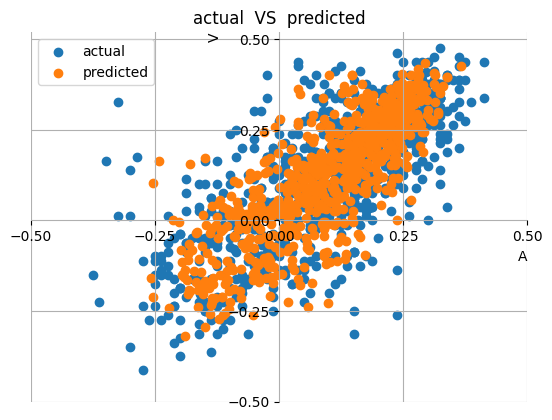

In [11]:
# 简单可视化，绘制实际点与预测点对比图
plt.scatter(V-0.5,A-0.5,label="actual")
plt.scatter(rfr_v.predict(X_scaled)-0.5,rfr_a.predict(X_scaled)-0.5,label="predicted")
plt.xlabel('A',loc="right")
plt.ylabel('V',loc="top")
x_ticks = [-0.5,-0.25,0,0.25,0.5]
y_ticks = [-0.5,-0.25,0,0.25,0.5]
plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.title("actual  VS  predicted")
plt.legend()
plt.grid()

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))

由图可见，拟合结果比较好，预测点整体象限分布良好，相比实际点更向原点聚拢

In [12]:
# 数据集分割
train_x,test_x,train_v,test_v,train_a,test_a = train_test_split(X_scaled,V,A,test_size=0.2,random_state=44) 

In [13]:
# 网格搜索，调整参数（n_estimators，max_depth)
# param_grid = {'n_estimators':np.arange(105,130,5)
#             ,'max_depth':np.arange(11,15,1)
#             }
# rfr = RandomForestRegressor(n_jobs=-1)
# grid = GridSearchCV(rfr,param_grid=param_grid,cv=10) # 十折交叉验证
# grid.fit(train_x,train_v)
# # grid.fit(train_x,train_a)
# print('最优回归器:',grid.best_params_,'最优分数:', grid.best_score_)

In [14]:

rfr_v = RandomForestRegressor(n_estimators=120,max_depth=12,n_jobs=-1)
rfr_a = RandomForestRegressor(n_estimators=105,max_depth=8,n_jobs=-1)
rfr_v.fit(train_x,train_v)
rfr_a.fit(train_x,train_a)
# 输出V、A预测分数
print(rfr_v.score(test_x,test_v),rfr_a.score(test_x,test_a))
# print(test_v.index)
# print(test_a.index)
class1 = []
class2 = []
test_v.index = np.arange(153)
test_a.index = np.arange(153)
for i in range(153):
    class1.append(GetClass(test_v[i],test_a[i]))
    class2.append(GetClass(rfr_v.predict(test_x)[i],rfr_a.predict(test_x)[i]))
print(class1)
print(class2)
# 输出准确率
print(accuracy_score(class1,class2))

0.5528288902963724 0.7336969329671383
['Angry', 'peaceful', 'Happy', 'Happy', 'Happy', 'peaceful', 'Happy', 'Happy', 'Happy', 'Happy', 'peaceful', 'Angry', 'Sad', 'Sad', 'Happy', 'Happy', 'Angry', 'Sad', 'Angry', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Sad', 'Sad', 'Sad', 'peaceful', 'Angry', 'Happy', 'Happy', 'Sad', 'Angry', 'Angry', 'Happy', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'peaceful', 'Sad', 'Happy', 'Happy', 'Angry', 'peaceful', 'Angry', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'peaceful', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Angry', 'Happy', 'Angry', 'Happy', 'Angry', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy

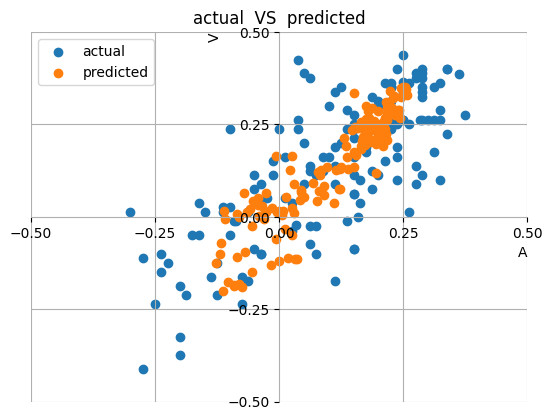

In [15]:
# 简单可视化，绘制实际点与预测点对比图
plt.scatter(test_v-0.5,test_a-0.5,label="actual")
plt.scatter(rfr_v.predict(test_x)-0.5,rfr_a.predict(test_x)-0.5,label="predicted")
plt.xlabel('A',loc="right")
plt.ylabel('V',loc="top")
x_ticks = [-0.5,-0.25,0,0.25,0.5]
y_ticks = [-0.5,-0.25,0,0.25,0.5]
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title("actual  VS  predicted")
plt.legend()
plt.grid()

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))